## Jaxa_Report_2022 on use of ALOS-2 data

#### created March 2022 for fuel update in F20 forest management unit

#### Land cover satellite imagery classification of multisource data
#### ALOS-2  and Sentinel-2 data


Step 1: Our collected training sites polygons have ASLC codes (i.e. 40, 51..552) We convert this polygons shape file to a raster using ASLC code for value and attach this raster layer to our Sent-2 image. Now, we have a stack of 11 chanel image including 10 Sentinel-2 bands and 1 chanel indicating ASLC codes from ground truth.

Step 2: Now, we run following 'play_vec.py' to generate point at each cell within our training polygons. In addition to this shapefile, this script converts ground truth shapefile to raster but needs a fix to assign correct ASLC code to each raster cell

In [ ]:
import ogr, os, sys
import numpy as np
import random
import gdal
import sys,os
try:
    from osgeo import ogr, osr, gdal
except:
    sys.exit('ERROR: cannot find GDAL/OGR modules')
from shapely.geometry import Polygon, Point
version_num = int(gdal.VersionInfo('VERSION_NUM'))
from osgeo import osr,ogr
if version_num < 1100000:
    sys.exit('ERROR: Python bindings of GDAL 1.10 or later required')

import shapely.wkt
from shapely.geometry import Point, Polygon
from shapely import speedups
import osgeo.ogr, osgeo.osr
#open an image and get info ......
gdal.UseExceptions()

In [ ]:
!pwd
# !pip install — upgrade bamboolib — user   # WORKS ONLY IN JUPYTER NOTEBOOK
#import bamboolib as bam
# !pip install fiona
!pip install pyrsgis
!pip install rasterio
!pip install scikit-learn

/content
     |████████████████████████████████| 19.3 MB 4.6 MB/s 


In [ ]:
# os.mkdir(path)
#Authenticate to Colab and Cloud
from google.colab import auth
auth.authenticate_user

<function google.colab.auth.authenticate_user>

### Mount drive so you can have control over your folders
Authentication

In [ ]:
from google.colab import drive
drive.mount('/content/deep_learn')

Mounted at /content/deep_learn


In [ ]:
#changd directory
path = "/content/deep_learn//MyDrive/Jaxa_2022"
%cd $path
#%cd "/content/deep_learn//MyDrive/Jaxa_2022"

/content/deep_learn/MyDrive/Jaxa_2022


In [ ]:
# upload files to your google drive
from google.colab import files
uploaded = files.upload()

Saving S2_Ph_32611_20m_4Predict_1.tif to S2_Ph_32611_20m_4Predict_1.tif


In [ ]:
# IMPORT more LIBRARIES
#Keras and TensorFlow are two packages for createing neural network models
import numpy as np
import os
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
#import NN layers and other components
# from sklearn import datasets
# Import Keras modules
#
from keras import models
from keras import layers
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense,Activation, BatchNormalization, Dropout
from keras.regularizers import l2
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn import metrics

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.constraints import max_norm

In [ ]:
!pwd

/content/deep_learn/MyDrive/Jaxa_2022


In [ ]:
!ls

F20_pnts_clean_March14_.csv		 S2_Ph_32611_20m_4Predict_1.tif
model_17class84pct_88.h5		 S2_Ph_32611_20m_4Predict.tif
my_best_np_CVSearch_model_NORMal_1.hdf5


### DATA PREPARATION
Introduction:

-For the start, We selected several ASLC classes burn-41, Sb-51, Pl-52, Sw-53, mixed conifer-54, decidusous-55 and water 80.

-One atribute - 'ASLC_1' was added to the dataframe and id number from 1 to 7 was assigned to.

-The rest of the data preparation included balancing and normalization. For balancing the data we used ~600 samples as average. therefore, some classes had to be up-sampled while others had to be down-sampled. There are many ways to normalize the data, but in this case we used Std and mean to bring them under standardized normal distribution

-to be able to measure the quality of our model we did SPLIT the data onto training set and validation set in ratio 8:2

Then we created an initial model where we used parameters generated from GridSearchCV during optimatzation process.

In [ ]:
# dataset_ar = np.loadtxt('F20_4_DL_14Nov.csv', delimiter="," ,skiprows=1) #
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset
filename =  'F20_pnts_clean_March14_.csv'  
# missing_values = ["n/a", "na", "--", 0]
#dataset = pd.read_csv(filename,na_values = missing_values)
dataset_ar = pd.read_csv(filename)
# dataset = pd.read_csv(filename, header = None)
list(dataset_ar)
#ASLC are  codes i.e. 51, 52,55..
#ASLC_ are id from 1 to 20 (total number of clases)

['X',
 'Y',
 'Z',
 'id',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B11',
 'B12',
 'Phi',
 'ASLC',
 'Latitude',
 'Longitude',
 'ASLC_']

In [ ]:
dataset_ar.tail()

,X,Y,Z,id,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,Phi,ASLC,Latitude,Longitude,ASLC_
5678,371348.0284,6569848.128,0,2940,291,590,383,248,582,1669,2027,2020,2166,1266,0.867016,552,371348.0284,6569848.128,17
5679,371368.0284,6569848.128,0,2941,277,624,410,270,640,1744,2084,2124,2277,1310,0.648082,552,371368.0284,6569848.128,17
5680,371328.0284,6569828.128,0,2968,296,612,393,255,626,1757,2143,2166,2337,1286,0.913669,552,371328.0284,6569828.128,17
5681,371348.0284,6569828.128,0,2969,299,619,438,288,621,1775,2129,2297,2262,1286,0.828769,552,371348.0284,6569828.128,17
5682,371368.0284,6569828.128,0,2970,270,643,393,269,634,1779,2125,2192,2264,1341,0.722980,552,371368.0284,6569828.128,17


### number of points(samples) for each ASLC class

In [ ]:
unique, counts = np.unique(dataset_ar['ASLC_'], return_counts=True)
list(zip(unique, counts))
# dataset['ASLC'].unique()

[(1, 560),
 (2, 447),
 (3, 84),
 (4, 1085),
 (5, 186),
 (6, 362),
 (7, 206),
 (8, 217),
 (9, 776),
 (10, 92),
 (11, 58),
 (12, 219),
 (13, 141),
 (14, 594),
 (15, 40),
 (16, 593),
 (17, 23)]

In [ ]:
#subset the dataset for columns we need. The features are Bands from B3 to B12. We excluded B2 (10m) just for sake
#of dimension reduction. 

dssel =dataset_ar[['B3','B4','B5', 'B6','B7', 'B8','B8A','B11','B12','Phi','ASLC_']]  #passing a list to it select multi cols. ASLC_ is (1-18)5
clasto10 = dssel[dssel["ASLC_"].isin([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])]
#clas6 = dssel[dssel["ASLC_"] < 6]
clasto10.tail()

,B3,B4,B5,B6,B7,B8,B8A,B11,B12,Phi,ASLC_
5678,590,383,248,582,1669,2027,2020,2166,1266,0.867016,17
5679,624,410,270,640,1744,2084,2124,2277,1310,0.648082,17
5680,612,393,255,626,1757,2143,2166,2337,1286,0.913669,17
5681,619,438,288,621,1775,2129,2297,2262,1286,0.828769,17
5682,643,393,269,634,1779,2125,2192,2264,1341,0.722980,17


###  DATA BALANCING
Balancing among classes is really important when it comes to accuracy assessment. First, we'll separate observations from each class into different DataFrames. 

Next, we'll resample the minority class with replacement, setting the number of samples to match that of the majority class.

Finally, we'll combine the up-sampled minority class DataFrame with the original majority class DataFrame.

In [ ]:
from sklearn.utils import resample

In [ ]:
# Separate majority and minority classes
#"majority"  means they stay without changes. while 'up' and 'down' means these
#classes need to be upsampled and downsampled.
df_1 = clasto10[clasto10.ASLC_==1]  #major ********stay the same
df_2 = clasto10[clasto10.ASLC_==2]   #majority ******stay the same
df_3 = clasto10[clasto10.ASLC_==3]  #up
df_4 = clasto10[clasto10.ASLC_==4]   #down
df_5 = clasto10[clasto10.ASLC_==5]    #up
df_6 = clasto10[clasto10.ASLC_==6]   #up
df_7 = clasto10[clasto10.ASLC_==7]    #up
df_8 = clasto10[clasto10.ASLC_==8]  #up
df_9 = clasto10[clasto10.ASLC_==9]   #down
df_10 = clasto10[clasto10.ASLC_==10]  #up
df_11 = clasto10[clasto10.ASLC_==11]   #up
df_12 = clasto10[clasto10.ASLC_==12]    #up
df_13 = clasto10[clasto10.ASLC_==13]   #up
df_14 = clasto10[clasto10.ASLC_==14]    #major  ******stay the same
df_15 = clasto10[clasto10.ASLC_==15]    #up
df_16 = clasto10[clasto10.ASLC_==16]   #majority  ******stay the same
df_17 = clasto10[clasto10.ASLC_==17]    #up
# Upsample minority class
df_3_upsampled = resample(df_3, replace=True,n_samples=500,random_state=123) 
df_5_upsampled = resample(df_5, replace=True,n_samples=500,random_state=123)
df_6_upsampled = resample(df_6, replace=True,n_samples=500,random_state=123)  
df_7_upsampled = resample(df_7, replace=True,n_samples=500,random_state=123)
df_8_upsampled = resample(df_8, replace=True,n_samples=500,random_state=123)  
df_10_upsampled = resample(df_10, replace=True,n_samples=500,random_state=123) 
df_11_upsampled = resample(df_11, replace=True,n_samples=500,random_state=123) 
df_12_upsampled = resample(df_12, replace=True,n_samples=500,random_state=123) 
df_13_upsampled = resample(df_13, replace=True,n_samples=500,random_state=123)
df_15_upsampled = resample(df_15, replace=True,n_samples=500,random_state=123)  
df_17_upsampled = resample(df_17, replace=True,n_samples=500,random_state=123) 
# Downsample majority class
df_4_downsampled = resample(df_4, replace=False,    # sample without replacement
                                 n_samples=500,     # to match minority class
                                 random_state=123) # reproducible results
df_9_downsampled = resample(df_9, replace=False,    # sample without replacement
                                 n_samples=500,     # to match minority class
                                 random_state=123) # reproducible results

In [ ]:
# Combine minority class with downsampled majority class
df_downUpsampled = pd.concat([df_1, df_2,df_3_upsampled ,df_4_downsampled,df_5_upsampled ,df_6_upsampled,df_7_upsampled,df_8_upsampled,df_9_downsampled,df_10_upsampled ,df_11_upsampled,df_12_upsampled,df_13_upsampled,df_14,df_15_upsampled,df_16,df_17_upsampled]) 


In [ ]:
# Display new class counts
df_downUpsampled.ASLC_.value_counts()

14    594
16    593
1     560
10    500
15    500
13    500
12    500
11    500
9     500
8     500
7     500
6     500
5     500
4     500
3     500
17    500
2     447
Name: ASLC_, dtype: int64

In [ ]:
# dataset_ar[0:8,-1]  #last column of first 8 rows
ds_array =df_downUpsampled.to_numpy()
uniques, count = np.unique(ds_array[:,-1], return_counts=True)
list(zip(uniques, count))

[(1.0, 560),
 (2.0, 447),
 (3.0, 500),
 (4.0, 500),
 (5.0, 500),
 (6.0, 500),
 (7.0, 500),
 (8.0, 500),
 (9.0, 500),
 (10.0, 500),
 (11.0, 500),
 (12.0, 500),
 (13.0, 500),
 (14.0, 594),
 (15.0, 500),
 (16.0, 593),
 (17.0, 500)]

### SPLITTING THE DATA INTO TRAIN AND TEST SUBDATASET

In [ ]:
#Step 3: Shuffle the rows before we start creating subsets for train and test data
import random
np.random.shuffle(ds_array)

In [ ]:
#look at the last column to make sure that rows were shuffled
ds_array.shape
ds_array[0:5,10]

array([16.,  5., 15.,  4., 14.])

In [ ]:
#Step 4: Split into Training/Validation Set in ratio 80:20

index_20percent = int(0.2 * len(ds_array[:, 0]))  #finds 20% of 1599 which is length of ds = 320
print(index_20percent)

XVALIDATION = ds_array[:index_20percent, :-1] # takes all  first 320 rows until the last column.
YVALIDATION = ds_array[:index_20percent, -1]  # takes all  first 320 rows JUst  last column.(labels)

# XVALIDATION
XTRAIN = ds_array[index_20percent:, 0:-1]  # takes all  rows from 320 to end  until the last column.
YTRAIN = ds_array[index_20percent:, -1]   # takes all  rows after 320 th row JUST the last column.(labesl)

1738


### Encoding
we need to transorm labels into an array. because labels can be strings or numbers and it is called 'hot encod' where label 1 and label 2 would look like [1. 0. 0. 0. 0. 0. 0.] [0. 1. 0. 0. 0. 0. 0.]

In [ ]:
encoder = LabelEncoder()
encoder.fit( YTRAIN)
encoded_Y_tr = encoder.transform( YTRAIN)

dummy_y_tr = np_utils.to_categorical(encoded_Y_tr)
# train_labels1 = YTRAIN
# train_labels = pd.get_dummies(train_labels1,prefix='Label')   #prefix 'Label' will be added to the table header in front 1.0, 2.0 etc
# test_labels = pd.get_dummies(test_labels1,prefix='Label')
# valid_labels = pd.get_dummies(valid_labels1,prefix='Label')
encoder_v = LabelEncoder()
encoder.fit( YVALIDATION)
encoded_Y_val = encoder.transform(YVALIDATION)

dummy_y_val= np_utils.to_categorical(encoded_Y_val)

In [ ]:
#when we do multiclass, then hot encoding is necessary
print(dummy_y_tr)
encoded_Y_tr

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


array([ 0, 16, 15, ...,  8, 11,  0])

In [ ]:
len(dummy_y_tr[0])  #number of classes

17

### NORMALIZATION FOR NUMPY ARRAY
#### **********************************************

In [ ]:

#axis =0 means vertical
mean = XTRAIN.mean(axis=0) 
std = XTRAIN.std(axis=0)
#x_train = x_train - mean

XTRAIN = XTRAIN -mean  
XTRAIN = XTRAIN/std

XVALIDATION =XVALIDATION- mean  #x_validation = x_validation - mean
XVALIDATION =XVALIDATION/ std    #x_validation = x_validation/std

# # 

In [ ]:
mean.shape
XTRAIN.shape

(6956, 10)

[6.58570874e+02 4.31238212e+02 2.99894623e+02 6.37584675e+02
 1.50215023e+03 1.75627803e+03 1.78663183e+03 1.89848088e+03
 1.25548907e+03 6.21309168e-01]
[3.55591314e+02 1.54104059e+02 1.33785076e+02 2.18764993e+02
 5.04492112e+02 6.04754935e+02 6.37061734e+02 6.65748343e+02
 5.16434332e+02 1.76304393e-01]


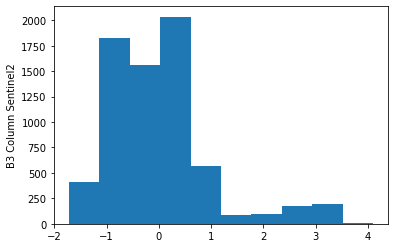

In [ ]:
print(mean)
print(std)
#plot for normalized acidity
plt.hist(XTRAIN[:, 0])
plt.ylabel('B3 Column Sentinel2')
plt.show()

In [ ]:
print(XTRAIN.shape)
print(YTRAIN.shape)
print("enc:",encoded_Y_tr.shape)
print(XVALIDATION.shape)
print(YVALIDATION.shape)

print(XTRAIN[0:3,])
# print(YTRAIN[0:3])
print("enc:",encoded_Y_tr[0:3])
print(XVALIDATION[0:3,])
print(YVALIDATION[0:3])

(6956, 10)
(6956,)
enc: (6956,)
(1738, 10)
(1738,)
[[ 2.62500542 -0.26759978  0.75572986  0.97097493 -0.15689092 -0.2352656
  -0.50015848 -0.32516924  1.66044523 -2.06041382]
 [ 0.28242851  1.1275614   0.44926817  0.47729449  0.94322539  0.91726737
   0.9000198   0.83743223  0.58383207 -0.25808138]
 [-0.1619018  -0.33249099 -0.56728767  0.45443891  0.3545145   0.28560654
  -0.06221034  0.36127633  0.02422559 -1.08888266]]
enc: [ 0 16 15]
[[ 0.05745114  0.67332288  0.59876168  1.00297274  0.66175419  0.53860159
   0.57979965  0.58658669  0.16364312 -0.84709464]
 [-0.7018475  -0.65694708 -0.85132533 -0.6563421  -0.54143608 -0.52463902
  -0.72619623 -0.56099408 -0.78517064  0.04921567]
 [ 0.15025431  2.77579832  2.39268375  1.62921553  0.56264462  0.41458441
   0.54997523  0.51899359  0.36696035 -0.81622981]]
[16.  5. 15.]


### Create a neural network model
A network with the following architecture:

• 18 NEURONS with ruleOfthumb ~features*2

• 8 neurons in layer 2, and

In [ ]:
#the best MODEL producing 84% accuracy WAS TUNED AND WE ASSEMBLE ANOTHER MODEL WITH NEW PARAMETERS
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
# # Input layer must have same input_shape as like number of features.
# # In case of multi-class classification, you can use softmax function as activation function.
# #No of neurons is 2*features
  #create model
network = models.Sequential()

network.add(layers.Dense(512,input_shape=(10,),kernel_initializer='lecun_uniform',activation='sigmoid',kernel_constraint=max_norm(2)))
#network.add(Dropout(0.1)) # Dropout is included if we have overfitting
network.add(layers.Dense(256,activation='sigmoid'))
network.add(layers.Dense(128,activation='sigmoid'))
network.add(layers.Dense(64,activation='sigmoid'))
network.add(layers.Dense(17,kernel_initializer='lecun_uniform',activation='softmax'))

  #complle model
  # optimizer=SGD(lr=learn_rate,momentum=momentum)
network.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:

from keras.callbacks import EarlyStopping,ModelCheckpoint
# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
# es = keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min',
#                                    patience=10, 
#                                    restore_best_weights=True) 
#                          # important - otherwise you just return the last weigths.

callback_a = keras.callbacks.ModelCheckpoint(filepath = 'my_best_np_CVSearch_model_NORMal_1.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20,restore_best_weights=True, verbose=1)

### Fitting the model

In [ ]:
## XTRAIN, YTRAIN, validation_data=(XVALIDATION, YVALIDATION),
# now we just update our model fit call
history = network.fit(XTRAIN, dummy_y_tr, validation_data=(XVALIDATION,dummy_y_val),
                    callbacks = [callback_a, callback_b],
                    epochs=200, # you can set this to a big number!
                    batch_size=60,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/200
90/93 [============================>.] - ETA: 0s - loss: 2.6480 - accuracy: 0.1226
Epoch 1: val_loss improved from inf to 2.30319, saving model to my_best_np_CVSearch_model_NORMal_1.hdf5
93/93 [==============================] - 2s 14ms/step - loss: 2.6387 - accuracy: 0.1240 - val_loss: 2.3032 - val_accuracy: 0.1983
Epoch 2/200
90/93 [============================>.] - ETA: 0s - loss: 2.1049 - accuracy: 0.2813
Epoch 2: val_loss improved from 2.30319 to 1.92378, saving model to my_best_np_CVSearch_model_NORMal_1.hdf5
93/93 [==============================] - 1s 8ms/step - loss: 2.0988 - accuracy: 0.2822 - val_loss: 1.9238 - val_accuracy: 0.2823
Epoch 3/200
93/93 [==============================] - ETA: 0s - loss: 1.8078 - accuracy: 0.3814
Epoch 3: val_loss improved from 1.92378 to 1.68529, saving model to my_best_np_CVSearch_model_NORMal_1.hdf5
93/93 [==============================] - 1s 8ms/step - loss: 1.8078 - accuracy: 0.3814 - val_loss: 1.6853 - val_accuracy: 0.4188
Epoch 4

### 6.2 EValuate model

####• Learning curves (Loss)(skip)

####• Learning curves (Accuracy)

####• Confusion matrix

In [ ]:
history_dict = history.history

	# learning curve
	# accuracy
  
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
	

	# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']
	

	# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

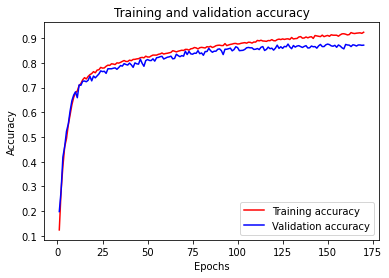

In [ ]:
# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

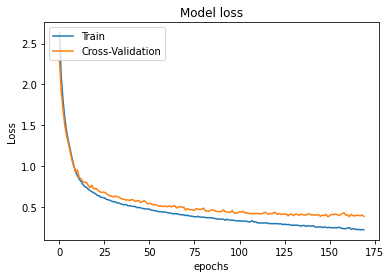

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

###  Save the model arhitecture to asingle file

In [ ]:
network.save("model_17class87pct_15March.h5")
print("save model to  a disk")

save model to  a disk


###  PREDICTING SOME VALUES

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
# x_new =np.array([[ 262,  145,  471, 1185, 1340, 1361 ,1451,  761 , 369]])
# voda = np.array([[66,  102 ,  84  , 65  , 69  , 67,   60 , 644 , 321]])
# sb = np.array([[260 , 112 , 470, 1185, 1339, 1360 ,1451,  762,  370]])
# dec = np.array([[308,  175 , 562, 2866, 3565 ,3772 ,3810, 1382 , 529]])
# preds = (network.predict(dec)>0.4).astype(int) # see how the model did!
preds = network.predict(XTRAIN) 
# print(preds)
#print(preds[0] )# i'm spreading that prediction across three nodes and they sum to 1
# print(np.sum(preds[0])) # sum it up! Should be 1

In [ ]:
# Almost a perfect prediction
# actual is left, predicted is top
# names can be found by inspecting Y
matrix = confusion_matrix(dummy_y_tr.argmax(axis=1), preds.argmax(axis=1))
matrix

array([[451,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,
          0,   0,   0,   0],
       [  0, 239,  15,  62,  21,   0,  10,   1,   4,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   3, 388,   0,   3,   0,   0,   0,   3,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,  30,   0, 335,  12,   3,  17,   1,   9,   0,   1,   0,   6,
          0,   0,   1,   0],
       [  0,  20,   1,  53, 301,   0,  25,   0,   2,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 338,   2,   7,  28,   0,   0,   2,   0,
          0,   0,   0,   4],
       [  0,   0,   2,  16,   3,   0, 354,   6,  11,   0,   0,   0,   0,
          0,   0,   0,   1],
       [  0,   0,   7,   0,   3,  25,  10, 367,  10,   0,   0,   3,   0,
          0,   0,   0,   1],
       [  0,   2,   5,   3,   3,  50,  38,  19, 283,   0,   0,   2,   1,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 404,   0,   0,   0,
         

In [ ]:
# more detail on how well things were predicted
print(classification_report(dummy_y_tr.argmax(axis=1), preds.argmax(axis=1)))
	##               precision    recall  f1-score   support

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       453
           1       0.81      0.68      0.74       352
           2       0.93      0.98      0.95       397
           3       0.71      0.81      0.76       415
           4       0.87      0.75      0.80       402
           5       0.80      0.89      0.84       381
           6       0.78      0.90      0.83       393
           7       0.90      0.86      0.88       426
           8       0.80      0.70      0.74       406
           9       1.00      1.00      1.00       404
          10       0.99      1.00      1.00       400
          11       0.98      0.97      0.97       406
          12       0.98      0.98      0.98       382
          13       0.95      0.91      0.93       480
          14       0.99      1.00      1.00       377
          15       0.92      0.94      0.93       483
          16       0.98      1.00      0.99       399

    accuracy              

Text(0.5, 1.0, 'Confusion matrix')

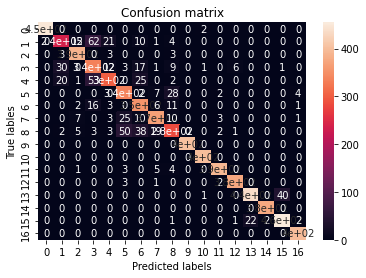

In [ ]:
from sklearn.metrics import confusion_matrix
ax = plt.subplot()
# # predict_results = model.predict(normed_test_data)

# #predict_results= (predict_results.argmax())
# predict_results= predict_results.argmax(axis=1)  #Radi
# predict_results=( predict_results> 0.5)
#cm = confusion_matrix(test_labels1,predict_results) #Radi

cm =confusion_matrix(dummy_y_tr.argmax(axis=1), preds.argmax(axis=1))
sns.heatmap(cm,annot=True,ax=ax);  #annotate cells
#labels , title, tics
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True lables')
ax.set_title('Confusion matrix')

#ax.xaxis.set_ticklabels(['Positive','Negative']) 
#ax.yaxis.set_ticklabels(['Positive','Negative']) 

In [ ]:
scores = network.evaluate(XVALIDATION, dummy_y_val)
print("\n%s: %.2f%%" % (network.metrics_names[1], scores[1]*100))

55/55 [==============================] - 0s 3ms/step - loss: 0.3574 - accuracy: 0.8832

accuracy: 88.32%


In [ ]:
predictions = network.predict(x=XVALIDATION,batch_size=10,verbose=0)
rounded_predictions = np.argmax(predictions,axis=-1)
for i in range(10):
  print(rounded_predictions[i])

15
4
14
3
13
2
5
6
3
5


 ### SAVE MODEL AND RESTORE IT FOR PREDICTION

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import colors
# !pip install rasterio
import rasterio
# !pip install pyrsgis
import pyrsgis
from pyrsgis.convert import changeDimension

In [ ]:
# in Tensorflow...
new_model = tf.keras.models.load_model("model_17class84pct_88.h5")

# #load model
# network_reload = load_model()
# # Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               5632      
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 17)                1105      
                                                                 
Total params: 179,217
Trainable params: 179,217
Non-trainable params: 0
_________________________________________________________________


###  Predicting labels on a unknown image
when we use a new image for prediction we have to make sure that we work with the same bands. if we used 9 of 10 bands to train a model, then we need to use the same bands for prediction

Also, if we trained model on normalized data we have to use the same parameters as we normalize new unknow image

In [ ]:
#Open an image (input data)
#img_path =r'/content/drive/MyDrive/aslc_20_cnn/play_2.dat'
img_path =r'/content/deep_learn/MyDrive/Jaxa_2022/S2_Ph_32611_20m_4Predict_1.tif' 
#smaller  - S2_Ph_32611_20m_4Predict_1.tif
# img_path = '/content/deep_learn/MyDrive/aslc_20_cnn/F_20_mosaic_ground_sub_4_pred_.tif' 
im_4_pred = rasterio.open(img_path)
im_4_predict = im_4_pred.read() 
# print(im_4_pred.count)
rows,cols = im_4_pred.shape
print("rows,cols:",rows,cols)
sizes = im_4_predict.shape
print("size:",sizes)
bands,height, width= sizes
print(bands,height,width)

rows,cols: 418 511
size: (14, 418, 511)
14 418 511


In [ ]:
#here we indicate what bands we are using for prediction
bands = [1,2,3,4,5,6,7,8,9,10] #we excluded the 1st band (0) which is blue 10m Sent2
#bands = [0,1,2,3,4,5,6,7,8,9] #this is the  full image bands array (10 and 20m bands)
#they start from 'B2' and end at 'B12'
#bands = [2,3,4,5,6,7,8,9]
for i in range(len(bands)):
  print(bands[i])

1
2
3
4
5
6
7
8
9
10


In [ ]:
out = np.zeros(sizes[1] * sizes[2],dtype='float32')
print("outsh:",out.shape)
output = out.reshape(sizes[1],sizes[2])
print("out:",output.shape)
#define output array for the classified image/result
# How many rows and columns?
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))
print(type(im_4_pred),im_4_pred.shape)

outsh: (213598,)
out: (418, 511)
Image size is: 418 rows x 511 columns

<class 'rasterio.io.DatasetReader'> (418, 511)


In [ ]:
# Loop throuhg the whole image
for y in range(rows):#rows
  for x in range(cols): #cols    
    ##############x_vec = new_img_norm [bands,y,x ]
    x_vec =im_4_predict[bands,y,x]  #selected Sentinel-2 bands   
    #normalize input image because model is based on  normalized data
    x_vect = (x_vec - mean)/std
    #we have ot reshape it tofit the model
    x_vect = np.reshape(x_vect,(1,10)) 

    preds = network.predict(x_vect)
    ind = np.argmax(preds)
    output[y,x] = ind

# EXPORT predicted image
# Register GDAL format drivers and configuration options with a
# context manager.
with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = im_4_pred.profile

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update( dtype=rasterio.uint8, count=1,   compress='lzw')

    with rasterio.open('predicted_play4_Normalized.tif', 'w', **profile) as dst:
        dst.write(output.astype(rasterio.uint8), 1)

# At the end of the ``with rasterio.Env()`` block, context
# manager exits and all drivers are de-registered.

In [ ]:
# (predsimg>0.4).astype(int)[0]
output.shape
output[:2,:10]

array([[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]], dtype=float32)

In [ ]:
#before we create a map of predicted image , we need to know what classes have been modeled.
# np.argmax([0, 0, 0, 0, 0, 1, 0])
np.unique(output)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.], dtype=float32)

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import colors

In [ ]:
#myCmap = colors.ListedColormap(['purple','lime','teal','limegreen','green', 'tomato','blue' ])  #number of colors has to match labels length unique
# myCmap = colors.ListedColormap(['purple','yellow','gold','limegreen','teal','lime','green', 'tomato','olivedrab','orangered','darkgoldenrod','blue','cyan','darkturquoise','khaki','blueviolet','magenta','orchid','yellowgreen','red'])
#15 classes
#myCmap = colors.ListedColormap(['purple','blue','red','green','teal','yellow','gold','limegreen','teal','lime','green', 'tomato','olivedrab','orangered','darkgoldenrod'])

myCmap = colors.ListedColormap(['#993300','green','#009999','#00FF00','#336600','red','#CCCC00','#CC3300','#CC6600','blue','cyan','#4ABDD9','yellow','#CC00CC','#CCFF33','#CCFF33','#00CC99'])

(3, 418, 511)


Text(0.5, 1.0, 'classified image')

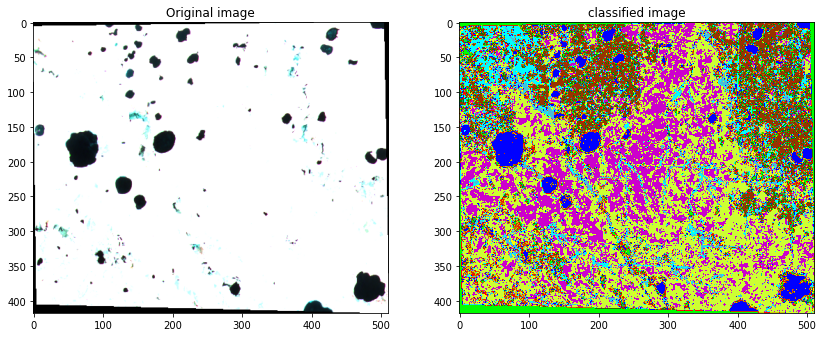

In [ ]:
#display the original image and predicted image
from rasterio.plot import reshape_as_image,reshape_as_raster
#display the original image
fig,axs = plt.subplots(1,2,figsize = (14,12))

index=np.array([9,7,5]) #9,7,3
colors = im_4_predict[index,:,:].astype(np.float64)
max_val =1000
min_val = 0
colors [colors[:,:,:] >max_val]=max_val
colors [colors[:,:,:] <min_val]=min_val
for b in range(colors.shape[0]):
  colors[b,:,:]=colors[b,:,:] *1/(max_val - min_val)
print(colors.shape)
colors_reshaped = reshape_as_image(colors)
colors_reshaped.shape
# print(colors_reshaped)
axs[0].imshow(colors_reshaped)
axs[0].set_title('Original image')

#display the classified image result
axs[1].imshow(output,myCmap)
axs[1].set_title('classified image')

# *****************************

## let's try improve model parameters to increase accuracy

## **Step : 9** Hyperparameters tuning for Deep Learning Models in Python

#### Using Grid Search in scikit-learn

Keras models can be used in scikit-learn by wrapping them with the KerasClassifier or KerasRegressor class. To use these wrappers you must define a function that creates and returns your Keras sequential model, then pass this function to the build_fn argument when constructing the KerasClassifier class

How to Use Grid Search in scikit-learn Grid search is a model hyperparameter optimization technique.In scikit-learn this technique is provided in the GridSearchCV class.When constructing this class you must provide a dictionary of hyperparameters to evaluate in the param_grid argument.

The constructor for the KerasClassifier class can take default arguments that are passed on to the calls to model.fit(),
The batch size in iterative gradient descent is the number of patterns shown to the network before the weights are updated. It is also an optimization in the training of the network, defining how many patterns to read at a time and keep in memory. The number of epochs is the number of times that the entire training dataset is shown to the network during training

In [ ]:
from keras.constraints import max_norm

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
# Function to create model, required for KerasClassifier
# def create_model( neurons=1):
#   #create model
#   model = Sequential()
#   model.add(layers.Dense(neurons,input_shape=(9,),kernel_initializer='lecun_uniform',activation='sigmoid',kernel_constraint=max_norm(2)))
#   model.add(Dropout(0.0))
#   model.add(layers.Dense(7,kernel_initializer='lecun_uniform',activation='softmax'))

#   #complle model
#   # optimizer=SGD(lr=learn_rate,momentum=momentum)
#   model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#   return model
#FOR GRIDSEARCHCV PARAMETER TUNNING ************************
#The function below is for parmaeter optimization

# Create the INITIAL network
#Output layer must have the same number of nodes as like number of classes in case of multi-class classification models.

def create_model():
  model.add(Dense(512,input_shape=(9,) ,activation='sigmoid') )
  model.add(Dense(256,activation='sigmoid'))
  model.add(Dense(128,activation='sigmoid'))
  model.add(Dense(64,activation='sigmoid'))
  model.add(Dense(7,kernel_initializer='lecun_uniform',activation='softmax'))

# Compile the network
  network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
#fix random seed for reproducibility
seed =7
np.random.seed(seed)
#create model
# model = KerasClassifier(build_fn=create_model,epochs=100,batch_size=60,verbose=0)
model = KerasClassifier(build_fn=create_model,verbose=0)
# #define grid search parameteres
batch_size=[10,20,40,60,80,100]
epochs=[10,100,200]
# learn_rate=[0.001,0.01,0.1,0.2,0.3  ]
# momentum=[0.0,0.2,0.4,0.6,0.8,0.9]
# weight_constraint=[1,2,3,4,5]
# dropout_rate=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9  ]
# neurons =[1,5,10,15,20,25,30]
#init_mode=['uniform','lecun_uniform','normal','zero','glorot_normal','glorot_uniform','he_normal','he_uniform']
#activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# param_grid=dict(batch_size=batch_size,epochs=epochs)
param_grid=dict(batch_size=batch_size,epochs=epochs)
grid=GridSearchCV(estimator=model,param_grid=param_grid,n_jobs=-1,cv=3)

In [ ]:
grid_result=grid.fit(XTRAIN, dummy_y_tr, callbacks = [callback_a, callback_b])

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

From this output we can see that 'batch_size': 60, 'epochs': 100 achieved the best results gaining 67% accuracy

Now, we go back to model and insert these two values

In the next step let's find out which optimizer gets best results. After model run 'optimizer': 'Adam'ended up as the best option, even though accuracy stay the same - 67%

54% using {'learn_rate': 0.001, 'momentum': 0.0}

74%6 using {'init_mode': 'lecun_uniform'}

Best: 0.734079 using {'activation': 'sigmoid'

Best: 0.715129 using {'dropout_rate': 0.0, 'weight_constraint': 2}

Best: 0.702392 using {'neurons': 30}